## Deep Q-Learning implementation for Cart Pole.

Set import path to ../src for common function and classes.

In [3]:
import sys

sys.path.append("../src/")

%load_ext autoreload
%autoreload 2

Determine Device

In [ ]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")

Using device: mps


Import all packages.

In [30]:
# Import necessary libraries
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable
import seaborn as sns
import shutil

import matplotlib.pyplot as plt

import cv2
import imageio

from utils import create_env, show
from base_agent import BaseAgent
from replay_memory import ReplayMemory, Transition
from summary_writer import LocalSummaryWriter


Neural Network for Deep Q-Learning with one hidden layer.

In [31]:
"""Deep Q Learning Network."""


class DQN(nn.Module):
    """Deep Q Network."""

    def __init__(self, in_size, out_size, num_hidden=128):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(in_size, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, out_size)

    def forward(self, x):
        """Forward pass through the network."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

RL Agent for training and running.

In [32]:
import time


class DQNAgent(BaseAgent):
    """DQN Agent that interacts with and learns from the environment."""

    # local_qnetwork--> selects the action
    # target_qnetwork --> calculate target queue values in the local network
    # double queue network stablizes the learning process
    def __init__(
        self,
        env: gym.Env,
        dqn: nn.Module,
        loss: Tensor,
        lr=0.001,
        eps_start=1.0,
        eps_end=0.1,
        eps_decay=0.995,
        batch_size=100,
        target_update=4,
        gamma=0.999,
        writer: LocalSummaryWriter = None,
    ):
        self.writer = writer
        self.logs = writer.log_dir
        self.env = env
        self.policy_net = dqn
        self.target_net = dqn

        # Set Target network parameters to be the same as the local network
        # This is done to stabilize the learning process
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.loss = loss
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.target_update = target_update
        self.gamma = gamma
        self.steps = 0

        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}

    def act(self, state: any, eps_thresh: float) -> Tensor:
        """Select new action based on the current state."""
        # epsilon greedy action selection
        # with probability eps_thresh select random action
        # otherwise select the action with the highest expected return
        sample = random.random()

        if sample > eps_thresh:
            with torch.no_grad():
                # select the optimal action based on the maximum expected return
                action = torch.argmax(self.policy_net(state)).view(1, 1)
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return action
        else:
            # Random action
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize(self) -> float:
        """Opitimize policy network via batch learning."""
        # If the memory is not full, we cannot sample a batch
        if len(self.memory) < self.batch_size:
            return 1.0

        sample_transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*sample_transitions, strict=False))

        # get a list that is True where the next state is not "done"
        has_next_state = torch.tensor(
            list(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool
        )
        next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        pred_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.

        next_state_values = torch.zeros(self.batch_size, device=device)
        # get the max along each row using the target network, then detach
        with torch.no_grad():
            # select the maximum Q value for each next state
            # and detach the result to avoid backpropagation through the target network
            next_state_values[has_next_state] = self.target_net(next_states).max(1)[0].detach()

        # Q(s, a) = reward(s, a) + Q(s_t+1, a_t+1)* gamma
        target_values = (next_state_values * self.gamma) + reward_batch

        # Compute loss
        loss = self.loss(pred_values, target_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.cpu().detach().numpy()

    def step(self, action: int) -> tuple[Tensor, Tensor, bool, bool]:
        """Take a step in the environment."""
        state, reward, done, terminated, _ = self.env.step(action)
        return (
            torch.FloatTensor([state]).to(device),
            torch.FloatTensor([reward]).to(device),
            done,
            terminated,
        )

    def train(self, episodes=100, smooth=100):
        """Training loop."""
        steps = 0
        pure_reward = []
        smoothed_reward = []
        elapsed_times = []
        mean_reward = 0
        eps_thresh = self.eps_start
        for episode in range(episodes):
            c_loss = 0
            c_samples = 0
            rewards = 0
            done = False
            truncated = False
            start_time = time.time()

            state, _ = self.env.reset()
            state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)

            while not done and not truncated:
                # get a decayed epsilon threshold
                eps_thresh = max(
                    self.eps_end,
                    eps_thresh - (self.eps_start - self.eps_end) * self.eps_decay,
                )
                action = self.act(state, eps_thresh)
                observation, reward, done, truncated = self.step(action.item())

                if done or truncated:
                    next_state = None
                else:
                    next_state = observation

                self.memory.push(state, action, next_state, reward)
                state = next_state

                loss = self.optimize()

                if steps % self.target_update == 0:
                    # update of the target network's weights
                    self.target_net.load_state_dict(self.policy_net.state_dict())

                rewards += reward.detach().item()
                steps += 1
                c_samples += self.batch_size
                c_loss += loss

                end_time = time.time()
                if done or truncated:
                    elapsed = end_time - start_time
                    break

            elapsed_times.append(elapsed)
            pure_reward.append(rewards)

            smoothed_reward.append(rewards)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.plots["Epsilon"].append(eps_thresh)
            self.plots["Reward"].append(rewards)
            self.plots["Mean Reward"].append(mean_reward)

            if episode % 20 == 0:
                print(
                    "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                        episode, rewards, mean_reward
                    )
                )

        print("\tTraining finished.")

        self.env.close()

        return elapsed_times, pure_reward, smoothed_reward

    def run(self, episodes=100):
        """Run/test the agent in the environment."""
        frames = []
        rewards = 0

        self.load()

        state = self.env.reset()[0]
        state = Variable(torch.from_numpy(state).float().unsqueeze(0)).to(device)
        done = False
        i = 0
        while not done:
            frame = self.env.render()
            frames.append(frame)

            action = torch.argmax(self.policy_net(state)).view(1, 1)
            next_state, reward, done, terminated, _ = self.env.step(action.item())
            state = Variable(torch.from_numpy(next_state).float().unsqueeze(0)).to(device)
            rewards += reward
            i += 1
            if done or terminated:
                print("Score: {} in {} steps".format(rewards, i))
                self.writer.add_scalar("Reward", rewards, i)
                break

        print("\tTotal Reward: ", rewards)
        print("\tSaving Animation ...")

        video_path = "%s/cartpole-movie.mp4" % self.logs
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, rewards

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="Mean Reward",
        )
        plt.legend()
        plt.title("DQN Gradient Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.logs, "rewards"))

    def save(self):
        """Save the model."""
        torch.save(self.policy_net.state_dict(), "%s/model.pt" % self.logs)

    def load(self):
        """Load the model."""
        self.policy_net.load_state_dict(torch.load("%s/model.pt" % self.logs))
        self.target_net.eval()

    def set_writer(self, writer: LocalSummaryWriter):
        """Set the summary writer."""
        self.writer = writer
        self.logs = writer.log_dir

Main function for running the experiments with given hyperparameters.

In [ ]:
def main(RL_hyperparams):
    """Train and Run the DQN agent."""
    torch.manual_seed(RL_hyperparams["random_seed"])
    np.random.seed(RL_hyperparams["random_seed"])
    random.seed(RL_hyperparams["random_seed"])

    rewards = []
    train_times = []
    run_times = []

    for i in range(1, RL_hyperparams["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, RL_hyperparams["number_of_experiments"]))

        path = f"../experiments/dqn_cartpole/run-{i}"
        shutil.rmtree(path, ignore_errors=True)

        writer = LocalSummaryWriter(path)
        writer.add_parameters(RL_hyperparams)

        if i == 1:
            env, num_states, num_actions = create_env(RL_hyperparams["env_name"])
            env.reset()

            dqn = DQN(num_states, num_actions).to(device)
            loss = nn.MSELoss()

            runner = DQNAgent(
                env,
                dqn,
                loss,
                batch_size=RL_hyperparams["batch_size"],
                lr=RL_hyperparams["lr"],
                gamma=RL_hyperparams["gamma"],
                eps_start=RL_hyperparams["eps_start"],
                eps_end=RL_hyperparams["eps_end"],
                eps_decay=RL_hyperparams["eps_decay"],
                target_update=RL_hyperparams["target_update"],
                writer=writer,
            )

            print("[Train]\tTraining Beginning ...")
            train_times, train_rewards, _ = runner.train(RL_hyperparams["num_episodes"], smooth=100)

            print("[Plot]\tPlotting Training Curves ...")
            runner.plot()

            print("[Save]\tSaving Model ...")
            runner.save()
        else:
            runner.set_writer(writer)
            runner.save()

        print("[Run]\tRunning Simulation ...")
        run_time, reward = runner.run()
        rewards.append(reward)
        run_times.append(run_time)

        print("[Video]\tShow Video ...")
        video_path = "%s/cartpole-movie.mp4" % path
        show(video_path)

    print("[End]\tDone. Congratulations!")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))

    print("[RunTime]\tAverage Run Time: ", np.mean(run_times))
    print("[RunTime]\tStandard Deviation of Run Time: ", np.std(run_times))
    print("[RunTime]\tMax Run Time: ", np.max(run_times))
    print("[RunTime]\tMin Run Time: ", np.min(run_times))

    print("[TrainingTime]\tAverage Training Time: ", np.mean(train_times))
    print("[TrainingTime]\tMax Training Time: ", np.max(train_times))
    print("[TrainingTime]\tMin Training Time: ", np.min(train_times))

    print("[TrainingReward]\tAverage Training Reward: ", np.mean(train_rewards))
    print("[TrainingReward]\tMax Training Rewards: ", np.max(train_rewards))
    print("[TrainingReward]\tMin Training Rewards: ", np.min(train_rewards))


Run the experiments.

[Experiment]	1 of 50
State Shape : (4,)
State Size : 4
Number of Actions : 2
[Train]	Training Beginning ...
	Episode 0 	 Final Reward 9.00 	 Average Reward: 9.00
	Episode 20 	 Final Reward 9.00 	 Average Reward: 10.00
	Episode 40 	 Final Reward 9.00 	 Average Reward: 9.73
	Episode 60 	 Final Reward 9.00 	 Average Reward: 9.62
	Episode 80 	 Final Reward 9.00 	 Average Reward: 9.53
	Episode 100 	 Final Reward 9.00 	 Average Reward: 9.67
	Episode 120 	 Final Reward 10.00 	 Average Reward: 9.67
	Episode 140 	 Final Reward 23.00 	 Average Reward: 9.90
	Episode 160 	 Final Reward 24.00 	 Average Reward: 11.14
	Episode 180 	 Final Reward 16.00 	 Average Reward: 12.70
	Episode 200 	 Final Reward 14.00 	 Average Reward: 13.22
	Episode 220 	 Final Reward 38.00 	 Average Reward: 14.26
	Episode 240 	 Final Reward 294.00 	 Average Reward: 25.82
	Episode 260 	 Final Reward 467.00 	 Average Reward: 55.05
	Episode 280 	 Final Reward 426.00 	 Average Reward: 87.68
	Episode 300 	 Final Reward 272.00 	 A

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 225.0 in 225 steps
	Total Reward:  225.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=225.0
duration=7.5
[Experiment]	2 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 171.0 in 171 steps
	Total Reward:  171.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=171.0
duration=5.7
[Experiment]	3 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 413.0 in 413 steps
	Total Reward:  413.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=413.0
duration=13.766666666666667
[Experiment]	4 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 220.0 in 220 steps
	Total Reward:  220.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=220.0
duration=7.333333333333333
[Experiment]	5 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 210.0 in 210 steps
	Total Reward:  210.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=210.0
duration=7.0
[Experiment]	6 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 484.0 in 484 steps
	Total Reward:  484.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=484.0
duration=16.133333333333333
[Experiment]	7 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 461.0 in 461 steps
	Total Reward:  461.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=461.0
duration=15.366666666666667
[Experiment]	8 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 245.0 in 245 steps
	Total Reward:  245.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=245.0
duration=8.166666666666666
[Experiment]	9 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 342.0 in 342 steps
	Total Reward:  342.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=342.0
duration=11.4
[Experiment]	10 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 256.0 in 256 steps
	Total Reward:  256.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=256.0
duration=8.533333333333333
[Experiment]	11 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 185.0 in 185 steps
	Total Reward:  185.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=185.0
duration=6.166666666666667
[Experiment]	12 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 227.0 in 227 steps
	Total Reward:  227.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=227.0
duration=7.566666666666666
[Experiment]	13 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 163.0 in 163 steps
	Total Reward:  163.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=163.0
duration=5.433333333333334
[Experiment]	14 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 281.0 in 281 steps
	Total Reward:  281.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=281.0
duration=9.366666666666667
[Experiment]	15 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 182.0 in 182 steps
	Total Reward:  182.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=182.0
duration=6.066666666666666
[Experiment]	16 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 186.0 in 186 steps
	Total Reward:  186.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=186.0
duration=6.2
[Experiment]	17 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 170.0 in 170 steps
	Total Reward:  170.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=170.0
duration=5.666666666666667
[Experiment]	18 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 233.0 in 233 steps
	Total Reward:  233.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=233.0
duration=7.766666666666667
[Experiment]	19 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 197.0 in 197 steps
	Total Reward:  197.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=197.0
duration=6.566666666666666
[Experiment]	20 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 183.0 in 183 steps
	Total Reward:  183.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=183.0
duration=6.1
[Experiment]	21 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 180.0 in 180 steps
	Total Reward:  180.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=180.0
duration=6.0
[Experiment]	22 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 438.0 in 438 steps
	Total Reward:  438.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=438.0
duration=14.6
[Experiment]	23 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 297.0 in 297 steps
	Total Reward:  297.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=297.0
duration=9.9
[Experiment]	24 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 281.0 in 281 steps
	Total Reward:  281.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=281.0
duration=9.366666666666667
[Experiment]	25 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 182.0 in 182 steps
	Total Reward:  182.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=182.0
duration=6.066666666666666
[Experiment]	26 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 182.0 in 182 steps
	Total Reward:  182.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=182.0
duration=6.066666666666666
[Experiment]	27 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 246.0 in 246 steps
	Total Reward:  246.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=246.0
duration=8.2
[Experiment]	28 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 345.0 in 345 steps
	Total Reward:  345.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=345.0
duration=11.5
[Experiment]	29 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 185.0 in 185 steps
	Total Reward:  185.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=185.0
duration=6.166666666666667
[Experiment]	30 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 171.0 in 171 steps
	Total Reward:  171.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=171.0
duration=5.7
[Experiment]	31 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 189.0 in 189 steps
	Total Reward:  189.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=189.0
duration=6.3
[Experiment]	32 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 228.0 in 228 steps
	Total Reward:  228.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=228.0
duration=7.6
[Experiment]	33 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 254.0 in 254 steps
	Total Reward:  254.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=254.0
duration=8.466666666666667
[Experiment]	34 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 161.0 in 161 steps
	Total Reward:  161.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=161.0
duration=5.366666666666666
[Experiment]	35 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 218.0 in 218 steps
	Total Reward:  218.0
	Saving Animation ...
[Video]	Show Video ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


frame per second=30.0
frame count=218.0
duration=7.266666666666667
[Experiment]	36 of 50
[Run]	Running Simulation ...
Score: 148.0 in 148 steps
	Total Reward:  148.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=148.0
duration=4.933333333333334
[Experiment]	37 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 189.0 in 189 steps
	Total Reward:  189.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=189.0
duration=6.3
[Experiment]	38 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 225.0 in 225 steps
	Total Reward:  225.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=225.0
duration=7.5
[Experiment]	39 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 233.0 in 233 steps
	Total Reward:  233.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=233.0
duration=7.766666666666667
[Experiment]	40 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 273.0 in 273 steps
	Total Reward:  273.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=273.0
duration=9.1
[Experiment]	41 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 161.0 in 161 steps
	Total Reward:  161.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=161.0
duration=5.366666666666666
[Experiment]	42 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 202.0 in 202 steps
	Total Reward:  202.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=202.0
duration=6.733333333333333
[Experiment]	43 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 181.0 in 181 steps
	Total Reward:  181.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=181.0
duration=6.033333333333333
[Experiment]	44 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 207.0 in 207 steps
	Total Reward:  207.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=207.0
duration=6.9
[Experiment]	45 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 268.0 in 268 steps
	Total Reward:  268.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=268.0
duration=8.933333333333334
[Experiment]	46 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 210.0 in 210 steps
	Total Reward:  210.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=210.0
duration=7.0
[Experiment]	47 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 168.0 in 168 steps
	Total Reward:  168.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=168.0
duration=5.6
[Experiment]	48 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 187.0 in 187 steps
	Total Reward:  187.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=187.0
duration=6.233333333333333
[Experiment]	49 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 368.0 in 368 steps
	Total Reward:  368.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=368.0
duration=12.266666666666667
[Experiment]	50 of 50
[Run]	Running Simulation ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Score: 202.0 in 202 steps
	Total Reward:  202.0
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=202.0
duration=6.733333333333333
[End]	Done. Congratulations!
[Reward]	Average Reward:  236.26
[Reward]	Standard Deviation of Reward:  79.60799206109898
[Reward]	Max Reward:  484.0
[Reward]	Min Reward:  148.0
[RunTime]	Average Run Time:  7.875333333333333
[RunTime]	Standard Deviation of Run Time:  2.6535997353699665
[RunTime]	Max Run Time:  16.133333333333333
[RunTime]	Min Run Time:  4.933333333333334
[TrainingTime]	Average Training Time:  0.933349883556366
[TrainingTime]	Max Training Time:  2.586261034011841
[TrainingTime]	Min Training Time:  0.015618085861206055
[TrainingReward]	Average Training Reward:  194.173
[TrainingReward]	Max Training Rewards:  500.0
[TrainingReward]	Min Training Rewards:  8.0


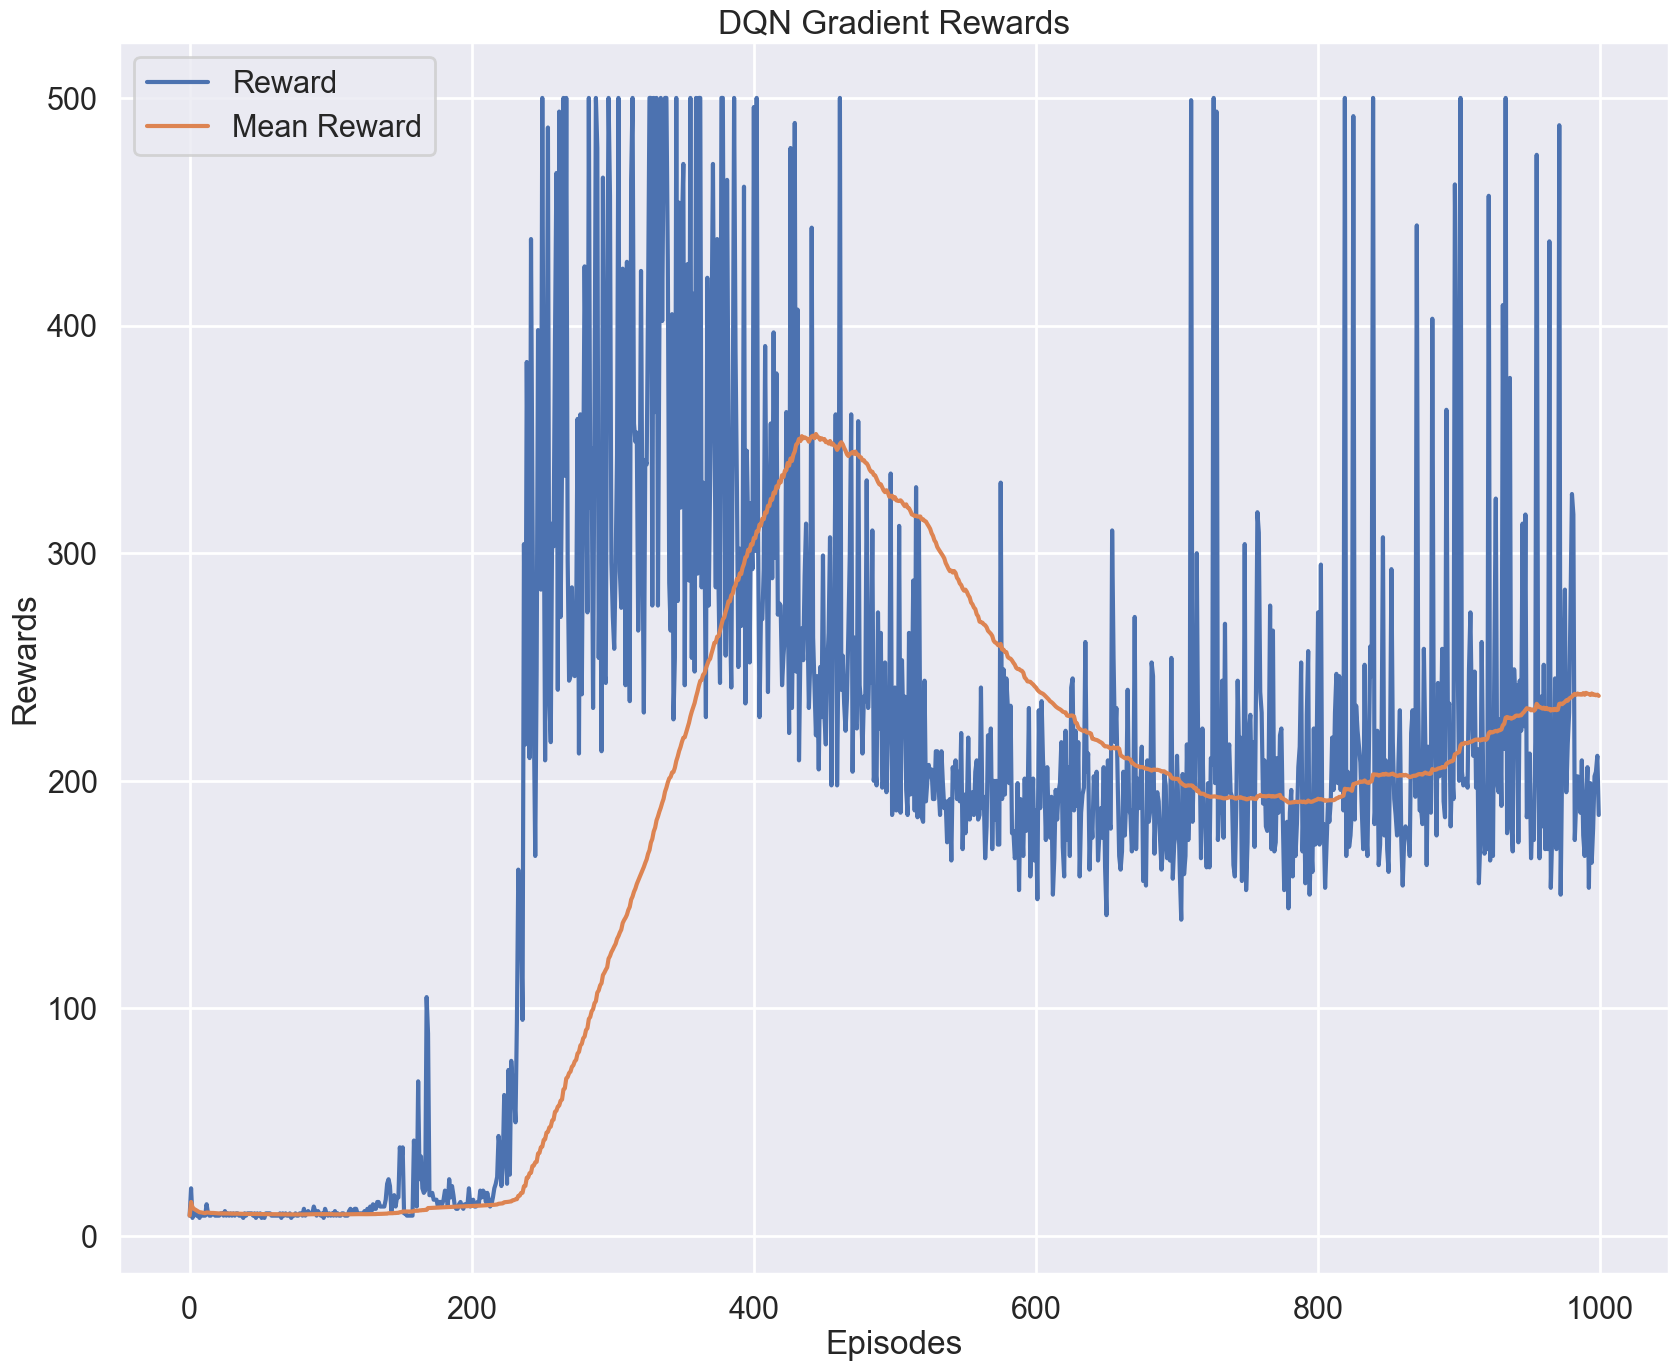

In [ ]:
if __name__ == "__main__":
    RL_hyperparams = {
        "env_name": "CartPole-v1",
        "number_of_experiments": 50,
        "num_episodes": 1000,
        "lr": 1e-4,
        "eps_start": 0.999,
        "eps_end": 0.01,
        "eps_decay": 0.999,
        "gamma": 0.93,
        "batch_size": 32,
        "target_update": 4,
        "random_seed": 42,
    }
    main(RL_hyperparams)